In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import sys
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch

sys.path.append('../')
from utils import project_root, BrainGraphDataset, get_data_labels

In [3]:
annotations = 'annotations.csv'
dataroot = f'fc_matrices/psilo_schaefer_before/'
root = project_root()

categories = ['patient_n','condition','bdi_before']

data_labels = get_data_labels()
data_labels = data_labels[categories]

data_labels.loc[data_labels["condition"] == "P", "condition"] = 1
data_labels.loc[data_labels["condition"] == "E", "condition"] = -1
data_labels['condition'] = data_labels['condition'].astype('float64')

# Load the dataset
dataset = BrainGraphDataset(img_dir=os.path.join(root, dataroot), 
                            annotations_file=os.path.join(root, annotations),
                            transform=None, extra_data=data_labels, setting='upper_triangular')

train_set, test_set = train_test_split(dataset, test_size=0.2)

# Create data loaders for train and test sets

train_loader = DataLoader(train_set, batch_size=len(train_set), shuffle=False)
test_loader = DataLoader(test_set, batch_size=len(test_set), shuffle=False)

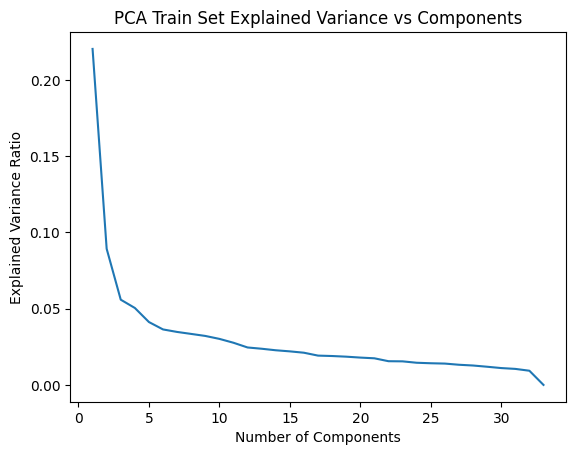

In [6]:
# Create a PCA object
pca = PCA(n_components=33)  # Set the maximum number of components to the original dimensionality


for X_batch, _ in train_loader:
    X_batch = X_batch.detach().numpy()
    pca.fit(X_batch)

# Plot the explained variance ratio
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Train Set Explained Variance vs Components')
plt.savefig('scree_pca_fit.png')
plt.show()


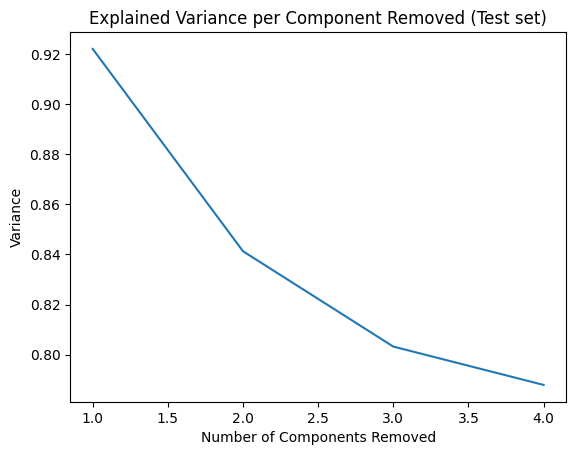

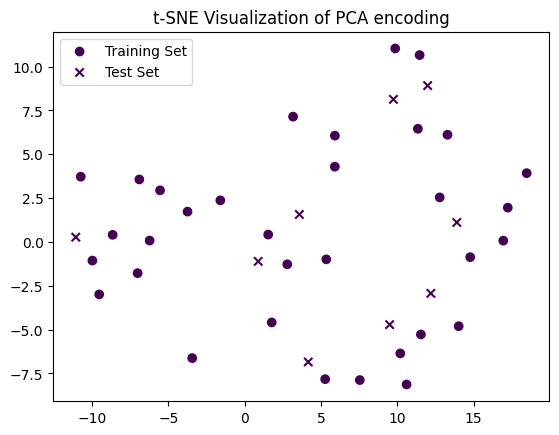

In [7]:
# Define a function to scale the input variables
def scale_data(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled

# Fit PCA on the training data
X_train = []
for X_batch, _ in train_loader:
    X_batch = X_batch.detach().numpy()
    X_train.append(X_batch)
X_train = np.concatenate(X_train, axis=0)
X_train_scaled = scale_data(X_train)

pca = PCA(n_components=4)  # Specify the desired number of components
X_train_pca = pca.fit_transform(X_train_scaled)

# Transform the test data using the trained PCA
X_test = []
for X_batch, _ in test_loader:
    X_batch = X_batch.detach().numpy()
    X_test.append(X_batch)
X_test = np.concatenate(X_test, axis=0)
X_test_scaled = scale_data(X_test)
X_test_pca = pca.transform(X_test_scaled)

# Calculate the variance per component removed
variance_per_component = []

for n_components in range(pca.n_components_, 0, -1):
    X_test_reconstructed = np.dot(X_test_pca[:, :n_components], pca.components_[:n_components, :])
    residual = X_test_scaled - X_test_reconstructed
    variance = np.var(residual)
    variance_per_component.append(variance)

# Plot the scree plot
plt.plot(range(pca.n_components_, 0, -1), variance_per_component)
plt.xlabel('Number of Components Removed')
plt.ylabel('Variance')
plt.title('Explained Variance per Component Removed (Test set)')
plt.savefig('scree_test.png')
plt.show()

# Combine the PCA-transformed features and labels from both sets
y_train = np.zeros(X_train_pca.shape[0])
y_test = np.ones(X_test_pca.shape[0])

X_combined = np.concatenate((X_train_pca, X_test_pca), axis=0)
y_combined = np.concatenate((y_train, y_test), axis=0)

# Perform t-SNE on the combined data
tsne = TSNE(n_components=2, random_state=42, perplexity=9)
X_combined_tsne = tsne.fit_transform(X_combined)

# Separate the combined t-SNE data into training and test portions
X_train_tsne = X_combined_tsne[:X_train_pca.shape[0]]
X_test_tsne = X_combined_tsne[X_train_pca.shape[0]:]

# Plot t-SNE visualization
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap='viridis', label='Training Set')
plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=y_test, cmap='viridis', marker='x', label='Test Set')
plt.title('t-SNE Visualization of PCA encoding')
plt.savefig('tsne_pca.png')
plt.legend()
plt.show()

Explained variance is markedly higher in the test set than the train set and decreases very little wrt to additional components, shows that PCA generalises the underlying relationship very poorly - likely non linear methods will outperform. 0.74 is the lowest variance achieved by test at 4 components which is stomped on by the test at 0.2 at 1 component.

The tSNE shows a very poor encoding - test and train distributions are wildly different in addition to no obvious clusters.